In [2]:
import time
import os,sys
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from IPython import display
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from stability_selection import StabilitySelection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
def update_progress(progress,line):
    '''
    update_progress() : Displays or updates a console progress bar
    Accepts a float between 0 and 1. Any int will be converted to a float.
    A value under 0 represents a 'halt'.
    A value at 1 or bigger represents 100%
    '''
    barLength = 50 # Modify this to change the length of the progress bar
    status = line
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float"
    if progress < 0:
        progress = 0
        status = "Halt..."
    if progress >= 1:
        progress = 1
        status = "Done..."+" "*50
    block = int(round(barLength*progress))
    text = "\rPercent: [{:s}] {:.2f}% {:s}".format( "█"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [126]:
test_data = pd.read_csv('../data/processed/test.csv')
train_data = pd.read_csv('../data/processed/train.csv')
submission_data = pd.read_csv('../reports/submission(0.816).csv')
vtrain_data = test_data.merge(submission_data,left_on='id', right_on='id')
vtrain_data['target'] = vtrain_data.target.apply(lambda x: 1 if x>0.8 else 0 if x<0.2 else x)
train_data = pd.concat([train_data,vtrain_data[(vtrain_data.target == 1) | (vtrain_data.target == 0)]])
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.to_csv('../data/processed/train_processed.csv',index = False)

In [8]:
class TrainDataset(Dataset):
    def __init__(self,path):
        self.input = pd.read_csv(path).drop(columns = ['id'])
        self.target = self.input.pop('target')
#         # Adding Extra features
#         self.input['mean'] = self.input.mean(axis=1)
#         self.input['median'] = self.input.median(axis=1)
#         self.input['std'] = self.input.std(axis=1)
#         self.input['var'] = self.input.var(axis=1)
#         self.input['min'] = self.input.min(axis=1)
#         self.input['max'] = self.input.max(axis=1)
        #Selecting features
#         self.input = self.input[self.input.corr()[self.input.corr().target.abs()>0.15].index]
#         #numerical columns
#         num_cols   = self.input.columns
#         #Scaling Numerical columns
#         self.std = PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
#         scaled = self.std.fit_transform(self.input)
#         self.input = pd.DataFrame(scaled,columns=num_cols)
        self.pipe = pipe = Pipeline(steps=[('scaler', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),('clf', LogisticRegression(solver='lbfgs', verbose=1, n_jobs=1, random_state=42))])
#         self.selectStabilizeFeature()
        self.selectSequentialFeature()
    
    def selectStabilizeFeature(self):
        Cs = np.logspace(-5, 5, 21)
        self.ss = StabilitySelection(base_estimator=self.pipe,lambda_name='clf__C', lambda_grid=Cs,n_jobs=-1, verbose=1, random_state=42)
        self.ss.fit(self.input, self.target)
        self.input = self.ss.transform(self.input)
        
    def selectSequentialFeature(self):
        cv = RepeatedStratifiedKFold(2, 50, random_state=42)
        self.sfs = SequentialFeatureSelector(self.pipe, k_features=(5,6), floating=True,scoring='roc_auc', cv=cv, verbose=1, n_jobs=2)
        self.sfs.fit(self.input, self.target)
        self.input = self.sfs.transform(self.input)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        data = self.input[idx]
        target = self.target[idx]
        return data,target

In [9]:
train_dataset = TrainDataset('../data/processed/train.csv')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   48.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:  5.0min finished
Features: 1/6[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   57.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 299 out of 299 | elapsed:  6.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


TypeError: unhashable type: 'slice'

In [180]:
train_dataset[0][0].shape

(14,)

In [181]:
len(train_dataset)

250

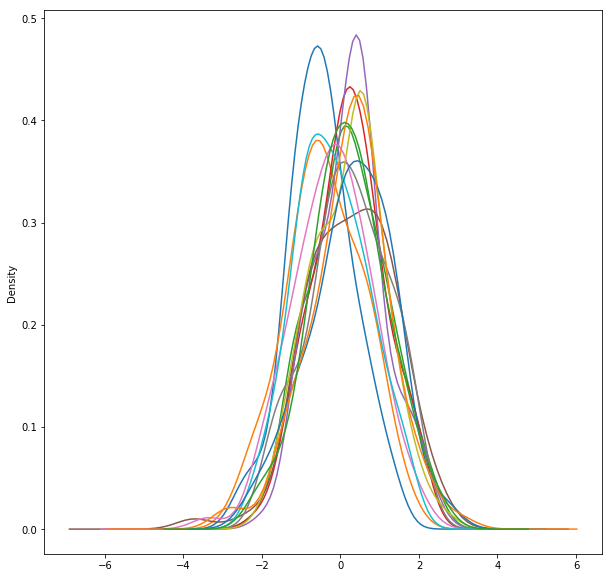

In [182]:
pd.DataFrame(train_dataset.input[train_dataset.target == 0.0]).iloc[:,1:].plot.kde(ind=100, legend=False, figsize=(10, 10))

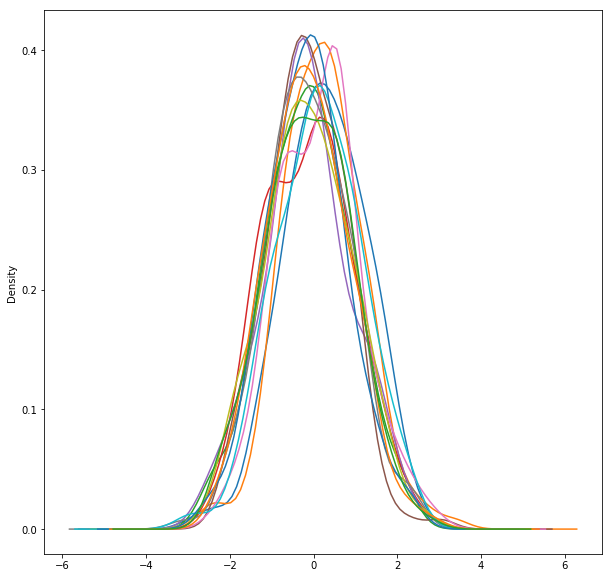

In [183]:
pd.DataFrame(train_dataset.input[train_dataset.target == 1.0]).iloc[:,1:].plot.kde(ind=100, legend=False, figsize=(10, 10))

In [184]:
batch_size = 2000
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
splitter = sss.split(train_dataset.input, train_dataset.target)
train_indices, val_indices = next(splitter)
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=val_sampler)

In [206]:
class Model(nn.Module):        
    def __init__(self):
        super(Model,self).__init__()
        self.layer1 = nn.GRU(14,128,2, bidirectional=True,dropout=0.1)
        
        self.layer2 = nn.Sequential(
            nn.Dropout2d(0.1),
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1,padding=1),
            nn.BatchNorm2d(32),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2))
        
        self.layer3 = nn.Sequential(
#             nn.Dropout2d(0.1),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1,padding=1),
            nn.BatchNorm2d(64),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2))
        
        self.layer4 = nn.Sequential(
#             nn.Dropout2d(0.1),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1,padding=1),
            nn.BatchNorm2d(128),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Dropout2d(0.1),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1,padding=1),
            nn.BatchNorm2d(256),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2))
        
        self.layer6 = nn.GRU(270,128,2, bidirectional=True,dropout=0.1)
        
        self.layer7 = nn.Bilinear(256,128*4,512)
        
        self.layer8 = nn.Sequential(
#             nn.Dropout(0.1),
            nn.Linear(512,1),
            nn.Sigmoid())
        
    def forward(self,x):
        output = x.unsqueeze(0)
        hidden = torch.zeros(4,output.size(1),128)
        if torch.cuda.is_available():
            hidden = hidden.cuda()
        output,hidden = self.layer1(output,hidden)
        output = F.relu(output.squeeze(0))
        output = output.view(-1,1,16,16)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.layer5(output)
        output = output.view(-1,256)
        output = torch.cat((output,x),dim=1)
        output = output.unsqueeze(0)
        output,hidden = self.layer6(output,hidden)
        output = F.relu(output.squeeze(0))
        hidden = hidden.view(-1,128*4)
        output = self.layer7(output,hidden)
        output = self.layer8(output)
        return output

In [207]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [208]:
model = Model()
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [209]:
# kwargs = torch.load('../models/model(0.xxx,0.1,NoTransform).pth')
# model = kwargs['model'].cpu()
# train_indices = kwargs['train_indices']
# val_indices = kwargs['val_indices']

In [210]:
def validate():
    total_loss = 0
    total_score = 0
    completed = 0
    model.eval()
    for batch_idx, (data,target) in enumerate(val_loader,start = 1):
        data = data.float()
        target = target.float()
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # forward
        output = model(data)
        # backward + optimize
        loss = criterion(output, target.view_as(output)).item()
        # print statistics
        score = roc_auc_score(target.cpu(), output.view_as(target).detach().cpu())
        total_score += score
        total_loss+=loss
        # print statistics
        completed += target.size(0)/len(val_indices)
        update_progress(completed,"Score: {:.4f} Loss: {:.4f}".format(score,loss))
    print("\nValidation Score:",round(total_score/batch_idx,4),'Validation Loss:',round(total_loss/batch_idx,4))
    return total_score/batch_idx

In [211]:
def train(epoch):
    total_loss = 0
    total_score = 0
    completed = 0
    model.train()
    exp_lr_scheduler.step()
    print("Epoch:",epoch,"Learning Rate:",exp_lr_scheduler.get_lr())
    for batch_idx, (data,target) in enumerate(train_loader,start = 1):
        data = data.float()
        target = target.float()
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # forward
        output = model(data)
        # backward + optimize
        loss = criterion(output, target.view_as(output))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print statistics
        score = roc_auc_score(target.cpu(), output.view_as(target).detach().cpu(), average='macro')
        total_score += score
        total_loss+=loss.item()
        # print statistics
        completed += target.size(0)/len(train_indices)
        update_progress(completed,"Score: {:.4f} Loss: {:.4f}".format(score,loss.item()))
    print("\nTrain Score:",round(total_score*100/batch_idx,4),'Train Loss:',round(total_loss/batch_idx,4))
    return total_score/batch_idx,validate()

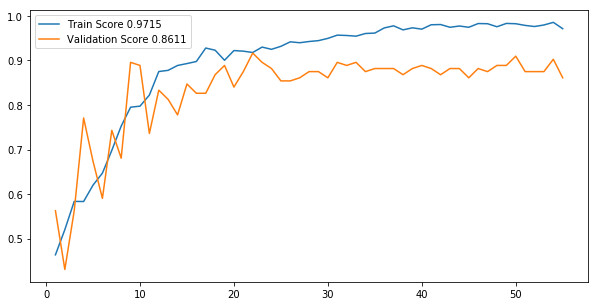

Epoch: 56 Learning Rate: [1e-05]


In [ ]:
train_data = []
val_data = []
epoch_data = []
for i in range(1,101):
    train_score,val_score = train(i)
    train_data.append(train_score)
    val_data.append(val_score)
    epoch_data.append(i)
    # Visualize
    plt.figure(figsize=(10,5))
    plt.plot(epoch_data, train_data,label="Train Score {:.4f}".format(train_data[-1]))
    plt.plot(epoch_data,val_data,label="Validation Score {:.4f}".format(val_data[-1]))
    display.clear_output(wait=False)
    plt.legend()
    plt.show()

In [662]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001,momentum=0.9,weight_decay=0.0005)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

## Naive Bayes

In [171]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_dataset.input, train_dataset.target, test_size=0.33, random_state=42)
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict_proba(X_test)[:,1]
# print(y_pred)
print(roc_auc_score(y_test,y_pred))

0.9564912280701755


In [234]:
pred = gnb.predict_proba(test_dataset.input.iloc[:,:].values)[:,1]

In [17]:
torch.save({'model':model,'train_indices':train_indices,'val_indices':val_indices},'../models/model(0.xxx,0.1,NoTransform).pth')

In [172]:
class TestDataset(Dataset):
    def __init__(self,path):
        self.input = pd.read_csv(path)
        self.ID = self.input.pop('id')
        self.input['mean'] = self.input.mean(axis=1)
        self.input['median'] = self.input.median(axis=1)
        self.input['std'] = self.input.std(axis=1)
        self.input['var'] = self.input.var(axis=1)
        self.input['min'] = self.input.min(axis=1)
        self.input['max'] = self.input.max(axis=1)
        #Selecting Freatures
        features = train_dataset.input.columns
        self.input = self.input[features]
        #numerical columns
        num_cols   = self.input.columns
        #Scaling Numerical columns
        scaled = train_dataset.std.transform(self.input)
        self.input = pd.DataFrame(scaled,columns=num_cols)
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        data = self.input.iloc[idx].values
        return data

In [173]:
test_dataset = TestDataset('../data/processed/test.csv')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [174]:
def predict():
    completed = 0
    pred = np.array([])
    model.eval()
    for batch_idx,data in enumerate(test_loader,start = 1):
        data = data.float()
        if torch.cuda.is_available():
            data = data.cuda()
        # forward
        output = model(data).view(-1)
        # print statistics
        completed += data.size(0)/len(test_dataset)
        update_progress(completed,"")
        pred = np.append(pred,output.detach().cpu().numpy())
    return pred

In [175]:
pred = predict()

Percent: [██████████████████████████████████████████████████] 100.00% Done...                                                  

In [176]:
submission = pd.DataFrame({'id':test_dataset.ID,'target':pred})

In [177]:
submission.to_csv('../reports/submission.csv',index=False)

In [178]:
sum(submission.target>.5)

14529

In [377]:
s = pd.read_csv('../reports/submission(0.9620).csv')

In [379]:
sum(s.target>0.5)

9799